In [1]:

import nltk
import pandas as pd
import re
import seaborn as sns
import gensim
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')



In this notebook, I will be working with a large labeled dataset of Twitter text, which has been labeled according to the sentiment orientation of the text. With 1.6 million tweets, this dataset presents a challenge in terms of extracting actionable insights, and the nature of the problem will be more focused on social media analysis from both a sentiment and topic perspective. To begin, I will clean and preprocess the data to make it easier to apply statistical analysis. From there, I will conduct topic modeling of the corpus, followed by sentiment analysis for different topics. By doing this analysis, I aim to uncover insights that can be derived from the data.

The notebook will be structured as follows:

- Data exploration, cleaning, and preprocessing
- Topic modeling
- Sentiment analysis classifier
- Sentiment analysis for different topics
- Sentiment analysis for the whole corpus.
- Conclusion, discussion, and business insights

In [2]:

nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /Users/ahmed/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ahmed/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Data Exploration,Cleaning and Preprocessing


In [3]:

tweets = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding = "ISO-8859-1")
tweets

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [4]:

tweets.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

In [5]:

# target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
# ids: The id of the tweet ( 2087)
# date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
# flag: The query (lyx). If there is no query, then this value is NO_QUERY.
# user: the user that tweeted (robotickilldozr)
# text: the text of the tweet (Lyx is cool)
tweets.columns = ['target','id','date','flag','user','text']


<AxesSubplot: title={'center': 'Sentiment Distribution'}>

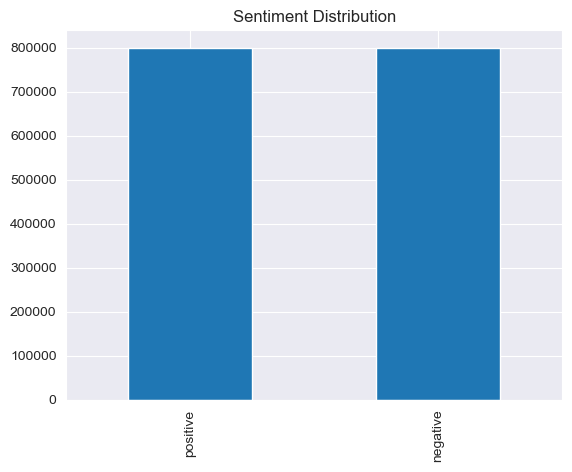

In [6]:

mapping = {0:"negative",4:"positive"}
tweets["sentiment"] = tweets["target"].map(mapping)
tweets["sentiment"].value_counts().plot(kind='bar',title='Sentiment Distribution')


<AxesSubplot: title={'center': 'User tweets distribution'}, ylabel='Frequency'>

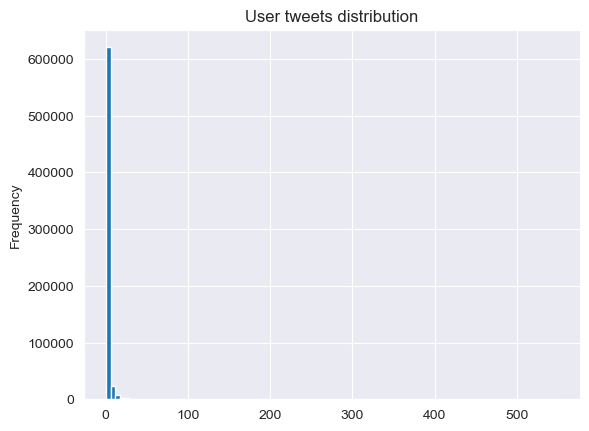

In [7]:

tweets["user"].value_counts().plot(kind="hist",bins=100,title="User tweets distribution")


In [8]:

tweets["text"].duplicated().sum()



18534

In [9]:

# we have many duplicated tweets:
duplicates = tweets[tweets.duplicated(subset=['text'], keep=False)]
duplicates


,target,id,date,flag,user,text,sentiment
53,0,1467821455,Mon Apr 06 22:22:32 PDT 2009,NO_QUERY,CiaraRenee,I need a hug,negative
127,0,1467841832,Mon Apr 06 22:27:55 PDT 2009,NO_QUERY,bgoers,I'm so cold,negative
212,0,1467863684,Mon Apr 06 22:33:35 PDT 2009,NO_QUERY,DjGundam,Awwh babs... you look so sad underneith that s...,negative
229,0,1467872175,Mon Apr 06 22:35:50 PDT 2009,NO_QUERY,edsed,I still can't find my keys.,negative
237,0,1467872759,Mon Apr 06 22:35:59 PDT 2009,NO_QUERY,Augustina22CA,"im lonely keep me company! 22 female, california",negative
...,...,...,...,...,...,...,...
1599500,4,2193453784,Tue Jun 16 08:28:49 PDT 2009,NO_QUERY,_cammi_,getting used to twitter,positive
1599530,4,2193474515,Tue Jun 16 08:30:28 PDT 2009,NO_QUERY,majaricious,@KhloeKardashian Definitely my Mom. And Angeli...,positive
1599677,4,2193503347,Tue Jun 16 08:32:47 PDT 2009,NO_QUERY,ShaneLemmon,goodmorning,positive
1599767,4,2193528075,Tue Jun 16 08:34:48 PDT 2009,NO_QUERY,rach3lizabeth,Good morning everyone.,positive


In [10]:

# drop duplicates but keep one of them:
tweets.drop_duplicates(subset=['text'], keep='first', inplace=True)


In [11]:

tweets["date"] = pd.to_datetime(tweets["date"])


In [12]:

# we will drop the flag and id columns as they are not useful for our analysis
tweets.drop(["flag","id","user"],axis=1,inplace=True,errors="ignore")


<AxesSubplot: title={'center': 'Tweets per year'}>

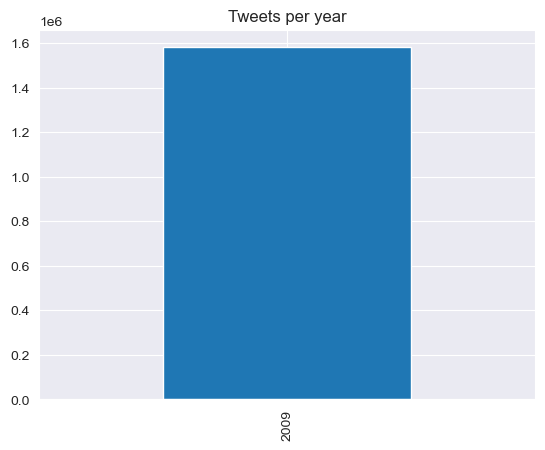

In [13]:

tweets["date"].dt.year.value_counts().plot(kind="bar",title="Tweets per year")


<AxesSubplot: title={'center': 'Tweets per month'}>

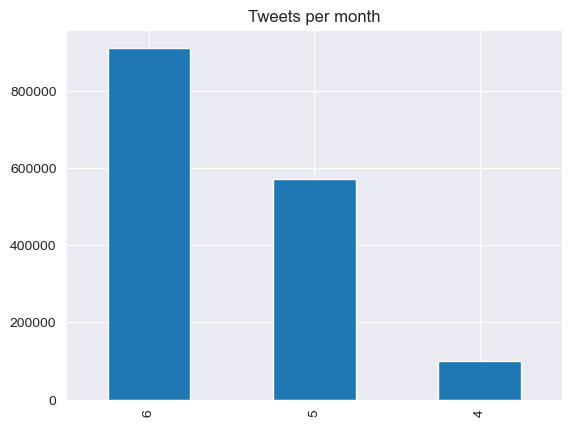

In [14]:

tweets["date"].dt.month.value_counts().plot(kind="bar",title="Tweets per month")


<AxesSubplot: title={'center': 'Tweets per day'}>

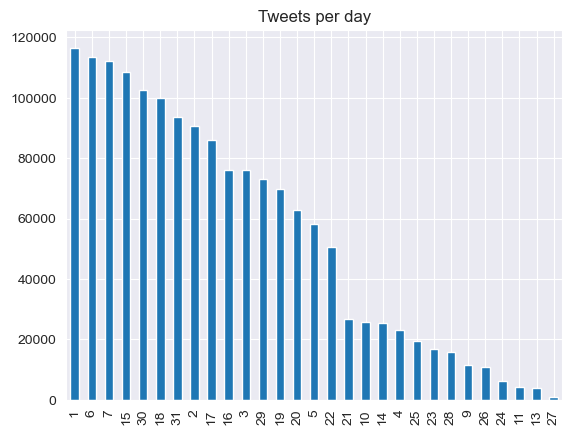

In [15]:

tweets["date"].dt.day.value_counts().plot(kind="bar",title="Tweets per day")


<AxesSubplot: title={'center': 'Tweets per day'}>

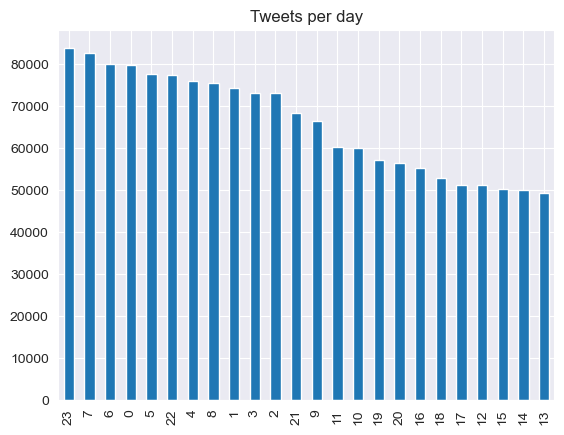

In [16]:

tweets["date"].dt.hour.value_counts().plot(kind="bar",title="Tweets per day")


In [17]:

tweets.sample(10)


,target,date,text,sentiment
192750,0,2009-05-30 01:43:56,"@danluvisiart God, I wanna see it! I can't unt...",negative
756887,0,2009-06-22 20:40:50,"and god damn, will someone please come give me...",negative
722440,0,2009-06-20 20:51:57,@nelsongeorge i never made it over this is th...,negative
783913,0,2009-06-25 02:06:27,I was going to buy something but I forgot what...,negative
1050457,4,2009-05-29 08:23:39,Thnk God for husbands that bring their wives c...,positive
409029,0,2009-06-06 17:09:16,"Sometimes I do hate long distance rltnshp,even...",negative
1515765,4,2009-06-15 01:34:31,"@chrissy_h You probably can. I mean, you can b...",positive
1459177,4,2009-06-07 03:51:46,Burn complete ! External DVD Drive A-Ok ! Yay !,positive
1389384,4,2009-06-06 03:20:09,@AnnaSaccone Thank you Anna!,positive
796778,0,2009-06-25 08:56:16,@eviljeanius -- try rappin your way out of tha...,negative


<AxesSubplot: xlabel='date', ylabel='count'>

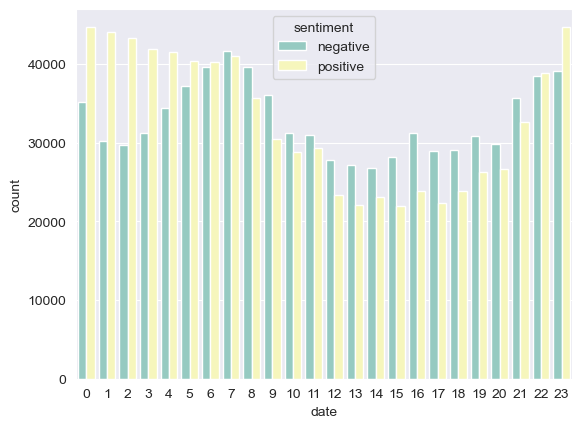

In [18]:
sns.countplot(x=tweets["date"].dt.hour,hue=tweets["sentiment"],data=tweets, palette="Set3")


<AxesSubplot: xlabel='date', ylabel='count'>

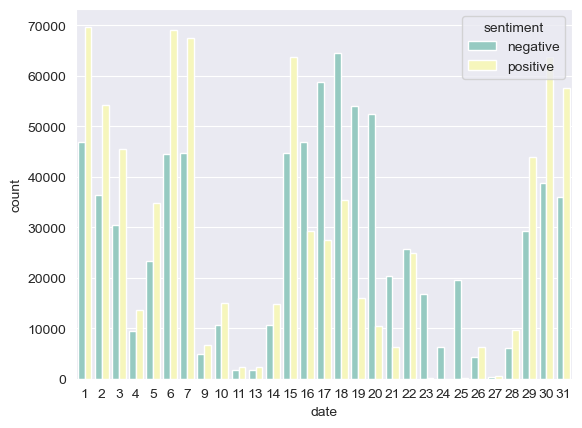

In [19]:

sns.countplot(x=tweets["date"].dt.day,hue=tweets["sentiment"],data=tweets, palette="Set3")


<AxesSubplot: xlabel='date', ylabel='count'>

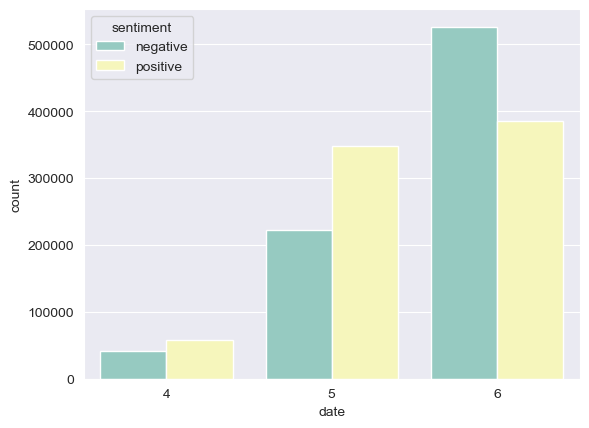

In [20]:

sns.countplot(x=tweets["date"].dt.month,hue=tweets["sentiment"],data=tweets, palette="Set3")


# Data Cleaning and preprocessing:

In [21]:

tweets.sample(10)


,target,date,text,sentiment
1560299,4,2009-06-15 18:39:52,@fluffykinz nah lol so you had back surgery r...,positive
619016,0,2009-06-18 13:36:06,@suzimuppet i hope that's a joke?,negative
525070,0,2009-06-16 08:52:15,"awk have to go back to school tonight ahh, it...",negative
1451472,4,2009-06-07 01:10:14,@creativejenius so i see u pulled one of my mo...,positive
1428733,4,2009-06-06 17:17:23,@Jonasbrothers - oooh what song is it for?,positive
853568,4,2009-04-21 00:10:42,Started working at the Wolf 1 year ago today &...,positive
1091416,4,2009-05-30 01:36:40,I've over-committed myself ... I'm sleeping so...,positive
1086342,4,2009-05-29 23:36:10,@markmackinnon you should upload some pictures,positive
387549,0,2009-06-06 06:23:59,Saw a snapping turtle on my run today! I think...,negative
1522212,4,2009-06-15 03:49:38,Hi @alexderossi! I saw Yanee's pics w/ you. Sh...,positive


In [22]:

punctuation = '!”$%&\’()*+,-./:;<=>?[\\]^_`{|}~•@'

def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)  # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')  # remove [links]
    tweet = re.sub(r'pic.twitter\S+', '', tweet)
    return tweet


def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet


def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet


def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet


def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet


def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = re.sub('📝 …', '', tweet)
    tweet  = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip()
    return tweet

# you can you this function to remove stop words:
def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result


def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')


In [23]:

tweets["clean_text"] = tweets["text"].apply(basic_clean)
tweets["deep_clean_text"] = tweets["text"].apply(preprocess_tweet)
tweets = tweets.drop(tweets[tweets['deep_clean_text'] == ''].index)


In [24]:

tweets.sample(100)


,target,date,text,sentiment,clean_text,deep_clean_text
1258994,4,2009-06-01 17:52:05,@moonfrye u r so right i think its cuz grownu...,positive,u r so right i think its cuz grownups bring al...,right think cuz grownups bring baggage judgments
1505572,4,2009-06-07 20:58:17,I finished folding all the pieces! All that is...,positive,i finished folding all the pieces all that is ...,finish fold piece leave glue
439202,0,2009-06-07 10:24:08,Want nap. Need nap. Can't have nap. No time fo...,negative,want nap need nap can't have nap no time for n...,want nap need nap nap time nap sad napless draw
197559,0,2009-05-30 06:00:51,@CrazyBallerina can't. my sal wont be in until...,negative,can't my sal wont be in until next week,sal wont week
175699,0,2009-05-29 15:05:22,I want another shake from Ritas.Badly.,negative,i want another shake from ritas badly,want shake ritas badly
...,...,...,...,...,...,...
1417311,4,2009-06-06 13:14:54,is pretty pleased with her eBay sales this mon...,positive,s pretty pleased with her ebay sales this mont...,pretty please ebay sales month plenty spend mo...
1059859,4,2009-05-29 12:33:24,@kirstencupcake Mine imagines himself a Squirr...,positive,mine imagines himself a squirrel slayer too,imagine squirrel slayer
745080,0,2009-06-22 11:01:00,@aromee omg mine just died. I don't wanna know...,negative,omg mine just died i don't wanna know how much...,omg die wanna know new
1114647,4,2009-05-30 09:55:45,"At the movies, we're trying to decide on a mov...",positive,at the movies we're trying to decide on a movi...,movies try decide movie


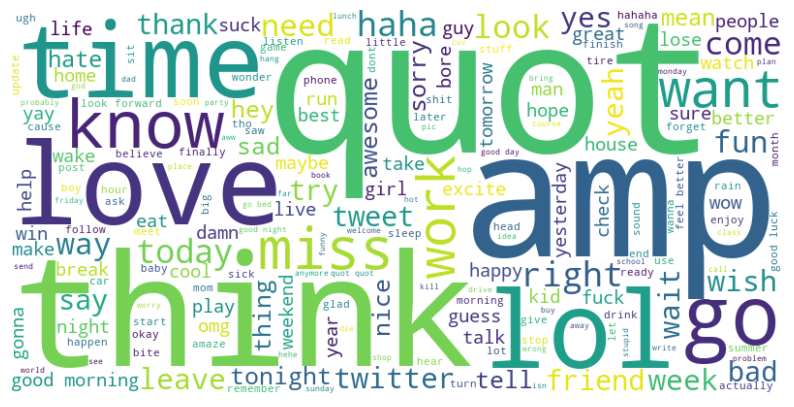

In [25]:

# concatenate all the text data into a single string
text = ' '.join(tweets['deep_clean_text'])

# create a WordCloud object with the text data
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# plot the WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Topic Modeling:

In [26]:

texts = tweets["deep_clean_text"].tolist()


texts = [d.split() for d in texts]

# Create Dictionary:
id2word = corpora.Dictionary(texts)

# create bag of words:
corpus = [id2word.doc2bow(text) for text in texts]

# Use TF-IDF
tfidf = models.TfidfModel(corpus)

corpus_tfidf = tfidf[corpus]



In [27]:

# iterate over topics
def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 20, limit = 30, step = 2)


model created
0.2577684727180028
model created
0.2267520114227666
model created
0.22661636559880968
model created
0.2281783301552877
model created
0.224499621619746


In [28]:

model = LdaMulticore(corpus=corpus,id2word = id2word, num_topics = 60, alpha=.1, eta=0.1, random_state = 422)
coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
print(coherencemodel.get_coherence())


0.25240837988118614


In [29]:

model.show_topics( )


[(12,
  '0.064*"game" + 0.032*"watch" + 0.012*"dead" + 0.011*"hubby" + 0.011*"get" + 0.011*"tune" + 0.010*"miss" + 0.010*"daddy" + 0.010*"mall" + 0.009*"sad"'),
 (56,
  '0.122*"tweet" + 0.023*"wait" + 0.020*"wrong" + 0.018*"line" + 0.016*"bet" + 0.015*"black" + 0.015*"sims" + 0.014*"sunny" + 0.014*"surprise" + 0.014*"gorgeous"'),
 (48,
  '0.033*"blog" + 0.028*"pics" + 0.024*"give" + 0.024*"site" + 0.021*"month" + 0.018*"check" + 0.016*"ipod" + 0.014*"touch" + 0.014*"new" + 0.012*"version"'),
 (45,
  '0.038*"rock" + 0.028*"perfect" + 0.023*"watch" + 0.018*"camp" + 0.017*"nope" + 0.016*"episode" + 0.016*"final" + 0.013*"go" + 0.011*"mark" + 0.011*"silly"'),
 (17,
  '0.025*"boy" + 0.024*"eye" + 0.015*"white" + 0.013*"company" + 0.012*"expect" + 0.012*"pink" + 0.010*"color" + 0.010*"nail" + 0.010*"screen" + 0.010*"mcfly"'),
 (26,
  '0.043*"aww" + 0.035*"study" + 0.035*"reply" + 0.030*"interest" + 0.025*"share" + 0.023*"sign" + 0.020*"set" + 0.015*"exams" + 0.013*"finals" + 0.012*"deserve"'

In [30]:

pyLDAvis.enable_notebook()

# Visualize the topics
lda_display = pyLDAvis.gensim.prepare(model, corpus_tfidf, id2word, sort_topics = True)
pyLDAvis.display(lda_display)


/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = 

In [33]:

# get the index of the set with the maximum second element, or the topic with the highest probability from list of topics:
def get_topic_probabilities(tweet):
    new_text_corpus = id2word.doc2bow(tweet.split())
    # get the index of the set with the maximum second element:
    max_index = max(enumerate(model[new_text_corpus]), key=lambda x: x[1][1])[1]
    topic_index = max_index[0]
    topic_probability = max_index[1]

    return topic_index, topic_probability


In [34]:

tweets['topic_index'], tweets['topic_probability'] = zip(*tweets['deep_clean_text'].apply(get_topic_probabilities))


<AxesSubplot: xlabel='topic_index', ylabel='Count'>

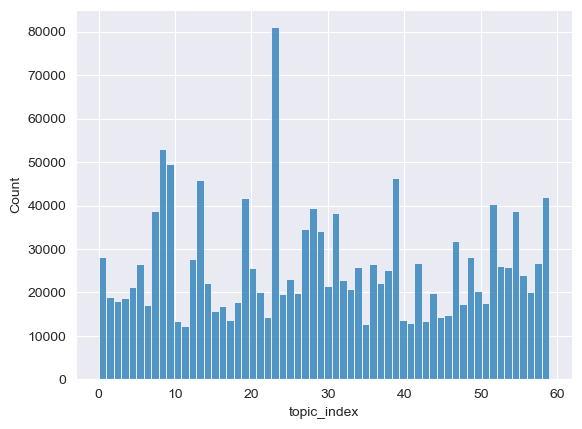

In [40]:


sns.histplot(tweets['topic_index'], bins=60)



### show top 20 words per most probable topic from our data:

In [46]:

# get top 10 topics:
topics_counts = tweets["topic_index"].value_counts()
top_10 = topics_counts.nlargest(10)
top_10 = top_10.index.tolist()
for topic in top_10:
    print(model.show_topic(topic, topn=20))
    print("----------------")


[('night', 0.09903526), ('go', 0.06707109), ('sleep', 0.060418025), ('bed', 0.04474513), ('good', 0.044058938), ('wake', 0.030343695), ('sunday', 0.022761134), ('early', 0.020236336), ('day', 0.018604442), ('work', 0.018048612), ('tomorrow', 0.01777184), ('saturday', 0.016148062), ('late', 0.014992452), ('time', 0.01495681), ('today', 0.012778006), ('home', 0.012409021), ('morning', 0.012252304), ('tonight', 0.01197703), ('nap', 0.009558305), ('crazy', 0.00940236)]
----------------
[('work', 0.19445096), ('excite', 0.04784914), ('tomorrow', 0.047446296), ('day', 0.044734556), ('life', 0.032498475), ('beautiful', 0.023408722), ('class', 0.02229332), ('go', 0.012023906), ('figure', 0.010702875), ('hmm', 0.010576111), ('today', 0.010405351), ('try', 0.009762935), ('way', 0.009335016), ('school', 0.009206163), ('mood', 0.008667667), ('final', 0.008271947), ('weekend', 0.00788439), ('fast', 0.007836405), ('tonight', 0.007065134), ('week', 0.006843956)]
----------------
[('haha', 0.1126033),

In [35]:

# save for later:
tweets.to_csv('tweets_clean_with_topics_new.csv', index=False)


# Deep Learning Model for Sentiment Analysis:
### where we explore building deep learning model per topic distribution:

In [52]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, Conv1D, Dropout, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# Choose a random color palette
color_palettes = ['BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']



/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:205: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/opt/anaconda3/lib/python3.9/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/opt/anaconda3/lib/python3.9/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/opt/anaconda3/lib/python3.9/site-packages/keras/utils/image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/opt/anaconda3/lib/python3.9/site-packages/keras/utils/image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be r

### Helper functions:

In [53]:

def get_population_per_topic(tweets, topic):
    # lest sample first:
    sample = tweets[tweets["topic_index"].isin(topic)]
    sample = sample[["clean_text", "target"]]
    sample['target'] = sample['target'].replace(4, 1)

    return sample


def get_embeddings_index():
    embeddings_index = {}
    with open('glove.6B.300d.txt', 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index


def get_embedding_matrix(embedding_dim, word_index, num_words, embeddings_index):
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


def get_model(embedding_dim, num_words, embedding_matrix, max_length):
    # Build model
    input_layer = Input(shape=(max_length,), name='input_layer')
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)
    conv_layer = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding_layer)
    max_pooling_layer = GlobalMaxPooling1D()(conv_layer)
    dense_layer = Dense(64, activation='relu')(max_pooling_layer)
    dropout_layer = Dropout(0.5)(dense_layer)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


def get_classification_report(test_labels, predicted_labels):
    print(classification_report(test_labels, predicted_labels))


def get_confusion_matrix(test_labels, predicted_labels, topic, camp):

    plt.figure()
    # Compute confusion matrix
    cm = confusion_matrix(test_labels, predicted_labels)

    # Normalize confusion matrix
    cm_norm = cm / cm.sum()

    # Visualize confusion matrix
    sns.heatmap(cm_norm, annot=True, cmap=camp, fmt='.2%', xticklabels=['negative', 'positive'],
                yticklabels=['negative', 'positive']).set(
        title="Confusion Matrix for Predicting Sentiment of the Tweet for Topic " + str(topic))

    plt.show()


def split_and_preprocess(sample):

    # Split data into training and testing sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(sample['clean_text'], sample['target'], test_size=0.4, random_state=42)

    # Tokenize texts
    # tokenizer = Tokenizer(num_words=10000)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_texts)
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    test_sequences = tokenizer.texts_to_sequences(test_texts)

    # Pad sequences
    max_length = max([len(sequence) for sequence in train_sequences])
    train_sequences = pad_sequences(train_sequences, maxlen=max_length)
    test_sequences = pad_sequences(test_sequences, maxlen=max_length)

    return  train_sequences,test_sequences,train_labels,test_labels, max_length, tokenizer

def get_f1_score(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    return f1


def get_accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy



In [55]:

embedding_dim = 300
embeddings_index = get_embeddings_index()


### Split and preprocess data per topic and train model using glove embeddings:

Metal device set to: Apple M1 Pro


2023-02-27 16:44:56.935818: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1013/1013 [==============================] - 6s 6ms/step - loss: 1.1348 - accuracy: 0.7431


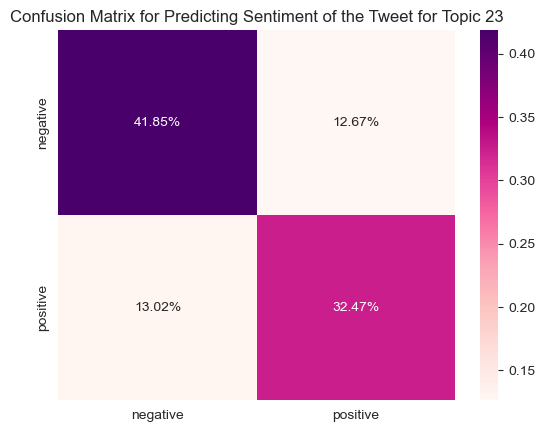

              precision    recall  f1-score   support

           0       0.76      0.77      0.77     17666
           1       0.72      0.71      0.72     14738

    accuracy                           0.74     32404
   macro avg       0.74      0.74      0.74     32404
weighted avg       0.74      0.74      0.74     32404

664/664 [==============================] - 4s 6ms/step - loss: 1.0689 - accuracy: 0.7361


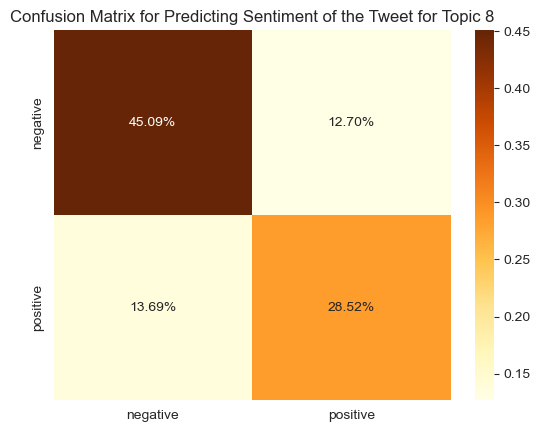

              precision    recall  f1-score   support

           0       0.77      0.78      0.77     12262
           1       0.69      0.68      0.68      8958

    accuracy                           0.74     21220
   macro avg       0.73      0.73      0.73     21220
weighted avg       0.74      0.74      0.74     21220

621/621 [==============================] - 5s 8ms/step - loss: 1.1274 - accuracy: 0.7234


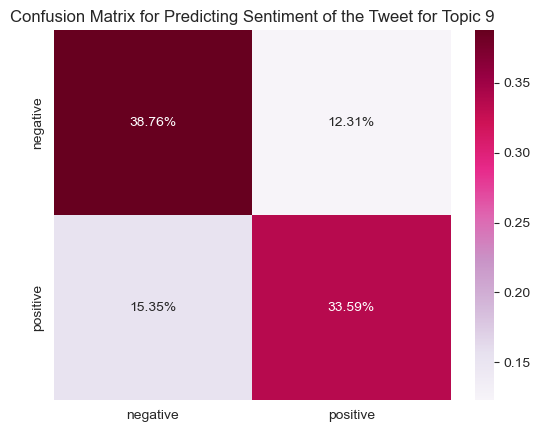

              precision    recall  f1-score   support

           0       0.72      0.76      0.74     10145
           1       0.73      0.69      0.71      9721

    accuracy                           0.72     19866
   macro avg       0.72      0.72      0.72     19866
weighted avg       0.72      0.72      0.72     19866

580/580 [==============================] - 4s 6ms/step - loss: 0.9578 - accuracy: 0.7736


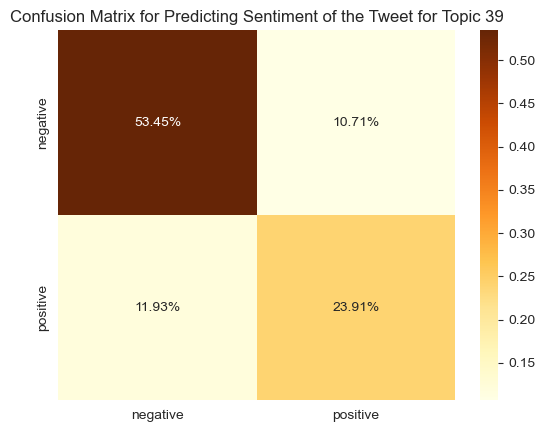

              precision    recall  f1-score   support

           0       0.82      0.83      0.83     11893
           1       0.69      0.67      0.68      6644

    accuracy                           0.77     18537
   macro avg       0.75      0.75      0.75     18537
weighted avg       0.77      0.77      0.77     18537

574/574 [==============================] - 3s 6ms/step - loss: 0.9916 - accuracy: 0.7730


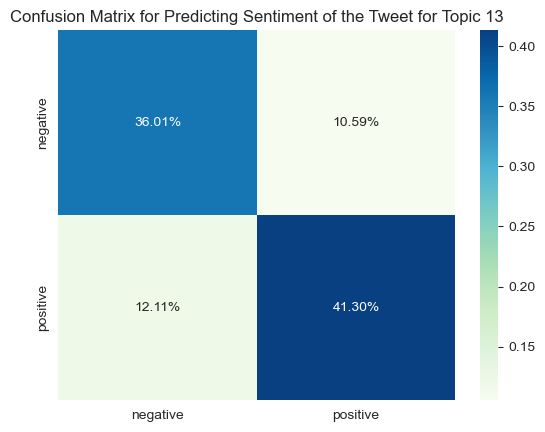

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      8556
           1       0.80      0.77      0.78      9808

    accuracy                           0.77     18364
   macro avg       0.77      0.77      0.77     18364
weighted avg       0.77      0.77      0.77     18364

525/525 [==============================] - 3s 7ms/step - loss: 1.2970 - accuracy: 0.7158


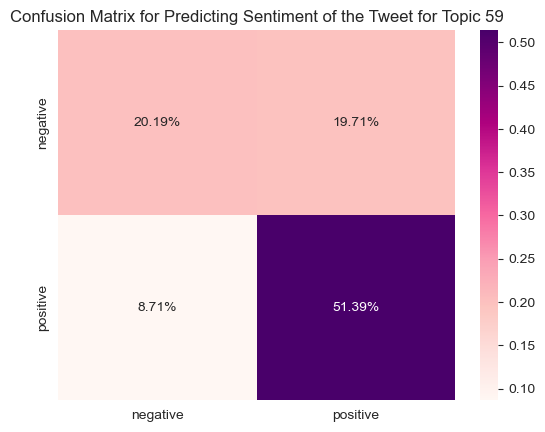

              precision    recall  f1-score   support

           0       0.70      0.51      0.59      6697
           1       0.72      0.86      0.78     10085

    accuracy                           0.72     16782
   macro avg       0.71      0.68      0.69     16782
weighted avg       0.71      0.72      0.71     16782

522/522 [==============================] - 3s 6ms/step - loss: 0.9184 - accuracy: 0.8017


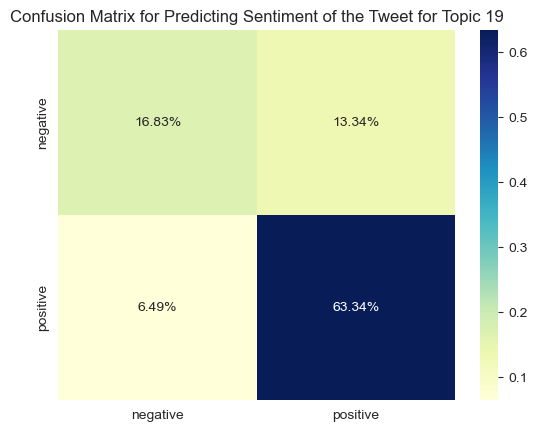

              precision    recall  f1-score   support

           0       0.72      0.56      0.63      5035
           1       0.83      0.91      0.86     11653

    accuracy                           0.80     16688
   macro avg       0.77      0.73      0.75     16688
weighted avg       0.79      0.80      0.79     16688

505/505 [==============================] - 3s 6ms/step - loss: 0.8438 - accuracy: 0.8113


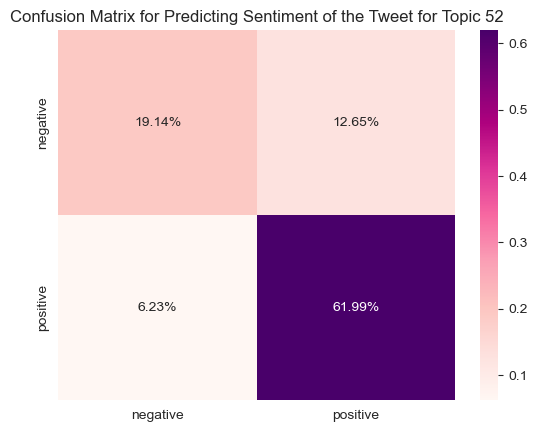

              precision    recall  f1-score   support

           0       0.75      0.60      0.67      5135
           1       0.83      0.91      0.87     11021

    accuracy                           0.81     16156
   macro avg       0.79      0.76      0.77     16156
weighted avg       0.81      0.81      0.80     16156

492/492 [==============================] - 4s 8ms/step - loss: 1.0466 - accuracy: 0.7560


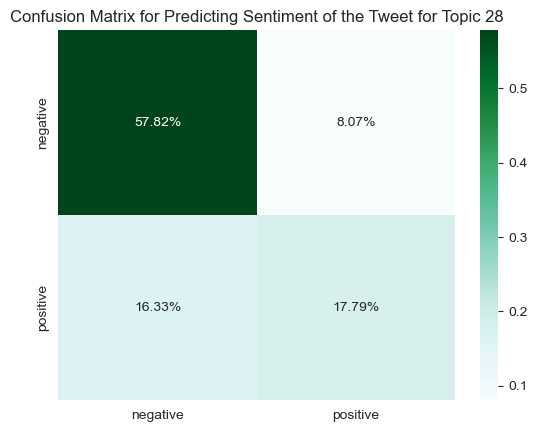

              precision    recall  f1-score   support

           0       0.78      0.88      0.83     10364
           1       0.69      0.52      0.59      5367

    accuracy                           0.76     15731
   macro avg       0.73      0.70      0.71     15731
weighted avg       0.75      0.76      0.75     15731

486/486 [==============================] - 3s 5ms/step - loss: 1.1633 - accuracy: 0.7403


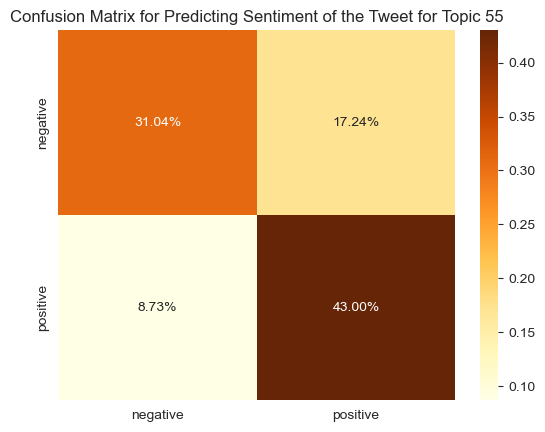

              precision    recall  f1-score   support

           0       0.78      0.64      0.71      7494
           1       0.71      0.83      0.77      8030

    accuracy                           0.74     15524
   macro avg       0.75      0.74      0.74     15524
weighted avg       0.75      0.74      0.74     15524



In [56]:

overall_results = []

for topic in top_10:
    # sample from topic 1:
    sample = get_population_per_topic(tweets, [topic])

    train_sequences, test_sequences, train_labels, test_labels, max_length, tokenizer = split_and_preprocess(sample)
    embedding_matrix = get_embedding_matrix(embedding_dim=embedding_dim, word_index=tokenizer.word_index,
                                            num_words=len(tokenizer.word_index), embeddings_index=embeddings_index)
    model = get_model(embedding_dim=300, num_words=len(tokenizer.word_index), embedding_matrix=embedding_matrix,
                      max_length=max_length)

    # Train model
    model.fit(train_sequences, train_labels, epochs=20, batch_size=520, validation_data=(test_sequences, test_labels),verbose=0)

    # Predict on test set
    predicted_labels = model.predict(test_sequences)
    predicted_labels = (predicted_labels > 0.5).astype(int)

    # Evaluate model
    loss, accuracy = model.evaluate(test_sequences, test_labels)

    get_confusion_matrix(test_labels,predicted_labels,topic, np.random.choice(color_palettes))

    get_classification_report(test_labels,predicted_labels)

    f1_score_ = get_f1_score(test_labels, predicted_labels)

    overall_results.append([topic, accuracy, f1_score_,loss])



In [57]:

overall_results = pd.DataFrame(overall_results, columns=['topic', 'accuracy', 'f1_score','loss'])
overall_results


,topic,accuracy,f1_score,loss
0,23,0.743149,0.716548,1.134807
1,8,0.736145,0.683762,1.068904
2,9,0.723447,0.708355,1.127380
3,39,0.773642,0.678763,0.957757
4,13,0.773034,0.784444,0.991579
5,59,0.715827,0.783395,1.297022
6,19,0.801654,0.864622,0.918444
7,52,0.811278,0.867889,0.843767
8,28,0.756023,0.593174,1.046649
9,55,0.740338,0.768080,1.163285


### Train Model on whole dataset:

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 117)]             0         
                                                                 
 embedding_10 (Embedding)    (None, 117, 300)          65036400  
                                                                 
 conv1d_10 (Conv1D)          (None, 115, 128)          115328    
                                                                 
 global_max_pooling1d_10 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                          

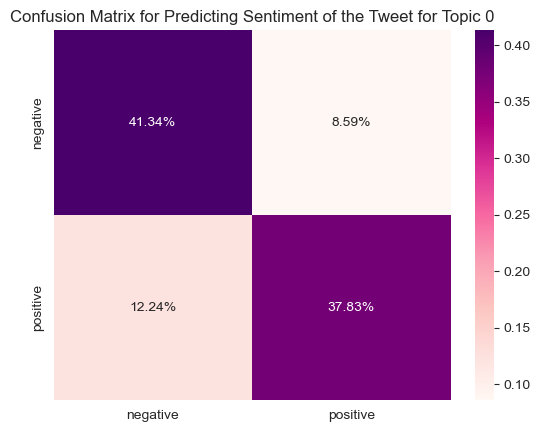

              precision    recall  f1-score   support

           0       0.77      0.83      0.80    312931
           1       0.81      0.76      0.78    313833

    accuracy                           0.79    626764
   macro avg       0.79      0.79      0.79    626764
weighted avg       0.79      0.79      0.79    626764



In [58]:

all_topics = tweets['topic_index'].tolist()

# sample from all topics:
sample = get_population_per_topic(tweets, all_topics)

train_sequences, test_sequences, train_labels, test_labels, max_length, tokenizer = split_and_preprocess(sample)
embedding_matrix = get_embedding_matrix(embedding_dim=embedding_dim, word_index=tokenizer.word_index,
                                        num_words=len(tokenizer.word_index), embeddings_index=embeddings_index)
model = get_model(embedding_dim=300, num_words=len(tokenizer.word_index), embedding_matrix=embedding_matrix,
                  max_length=max_length)
model.summary()

# Train model
model.fit(train_sequences, train_labels, epochs=30, batch_size=520, validation_data=(test_sequences, test_labels))

# Predict on test set
predicted_labels = model.predict(test_sequences)
predicted_labels = (predicted_labels > 0.5).astype(int)

# Evaluate model
loss, accuracy = model.evaluate(test_sequences, test_labels)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

get_confusion_matrix(test_labels,predicted_labels,0, np.random.choice(color_palettes))

get_classification_report(test_labels,predicted_labels)



In [60]:

overall_results["accuracy"].mean()



0.7574536263942718

In [61]:

overall_results["f1_score"].mean()



0.7449030084065679

In [62]:

overall_results



,topic,accuracy,f1_score,loss
0,23,0.743149,0.716548,1.134807
1,8,0.736145,0.683762,1.068904
2,9,0.723447,0.708355,1.127380
3,39,0.773642,0.678763,0.957757
4,13,0.773034,0.784444,0.991579
5,59,0.715827,0.783395,1.297022
6,19,0.801654,0.864622,0.918444
7,52,0.811278,0.867889,0.843767
8,28,0.756023,0.593174,1.046649
9,55,0.740338,0.768080,1.163285


# Conclusion, Discussion and business insights:

From exploring the data with time factor we can see that:
 - days of the month 1,2,3,6,7,15, 29,30,31 are the days with the most positive sentiment.
 - days of the month between 15 and 21 has the most negative sentiment.
 - June has the most negative tweets compare April and May.

While the problem of analyzing sentiment seems so straightforward as binary classification problem, given also the advancement of NLP models and large language models, I have made an attempt to analyze the data set from different perspective as shown in the notebooks, firstly experimented with LDA to extract the theme or the hidden latent structure of the topics behind tweet large corpus, in ab attempt to understand the data set better, while the topic coherence score was not very high, but still the extracted topics gives a sense on what are the main topics of the tweets are about, from the main most probable topics of the data we can understand:
 - Topics 23 hase large proportion of words such asL night, go, sleep, bed, work, sunday, morning, and home, we can see it's a topic about general discussion about the night and the morning, and the weekend, and the work, and the home, and the bed.
 -Topic 11 with top words such as happy, birthday, time, drink ,bottles, reflects birthday discussion or party.
 - Topic 39 wot common words like study, give, worry, hope, exams, doctor , and test, which is a topic about study and exams.
 - Topic 48 with words such morning, good, coffee, hangover, day, early reflects tweets about morning.
 - while it's hard to determine the sentiment orientation of each topic by inputting the top words, but we can see that the topics are about general discussion, birthday, study, morning, and hangover.

Building Deep Learning model:

- Mean accuracy for building separate models per most probable topics is 0.757 while F1 score of 0.7449, building model on whole data set archived high accuracy of 0.79 and F1 score of 0.79, building model for sentiment analysis problem on whole dataset is better decision for production environment.
- I have experimented with word embedding language model to extract embedding vectors per words from the data and use convolutional Neural Network to predict the sentiment orientation
- Topics 52, 19, 13 and 59 archived the highest score when it comes to F1 score.
- Topics 28, 39 and 8 archived lowest F1 score and accuracy.
- If we inspect topics 52, 19, 13 and 59 we can see that they are about more common words than topics 29, 39 and 8 which yields easier decision boundary for sentiment.

